In [1]:
import numpy as np
import configparser

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

import sys
sys.path.insert(0, '../lib/')
from help_functions import *

# function to obtain data for training/testing (validation)
from extract_patches import get_data_training

In [2]:
# Define the neural network
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

# Define the neural network gnet
# you need change function call "get_unet" to "get_gnet" in line 166 before use this network
def get_gnet(n_ch,patch_height,patch_width):
    inputs = Input((n_ch, patch_height, patch_width))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    up1 = UpSampling2D(size=(2, 2))(conv1)
    #
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)
    #
    up2 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)
    #
    up3 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up3)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)
    #
    up4 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up4)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)
    #
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool4)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    #
    conv10 = Convolution2D(2, 1, 1, activation='relu', border_mode='same')(conv9)
    conv10 = core.Reshape((2,patch_height*patch_width))(conv10)
    conv10 = core.Permute((2,1))(conv10)
    ############
    conv10 = core.Activation('softmax')(conv10)

    model = Model(input=inputs, output=conv10)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [3]:
# ========= Load settings from Config file
config = configparser.RawConfigParser()
config.read('configuration.txt')
# patch to the datasets
path_data = config.get('data paths', 'path_local')
# Experiment name
name_experiment = config.get('experiment name', 'name')
# training settings
N_epochs = int(config.get('training settings', 'N_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

In [4]:
# ============ Load the data and divided in patches
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original=path_data + config.get('data paths', 'train_imgs_original'),
    DRIVE_train_groudTruth=path_data + config.get('data paths', 'train_groundTruth'),  # masks
    patch_height=int(config.get('data attributes', 'patch_height')),
    patch_width=int(config.get('data attributes', 'patch_width')),
    N_subimgs=int(config.get('training settings', 'N_subimgs')),
    inside_FOV=config.getboolean('training settings', 'inside_FOV')  # select the patches only inside the FOV  (default == True)
)


train images/masks shape:
(20, 1, 565, 565)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

patches per full image: 9500

train PATCHES images/masks shape:
(190000, 1, 48, 48)
train PATCHES images range (min-max): 0.0 - 1.0


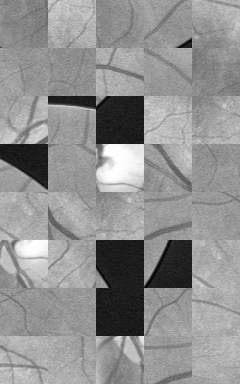

In [5]:
# ========= Save a sample of what you're feeding to the neural network ==========
N_sample = min(patches_imgs_train.shape[0], 40)
visualize(group_images(patches_imgs_train[0:N_sample, :, :, :], 5),
          './'+name_experiment+'/'+"sample_input_imgs")  # .show()

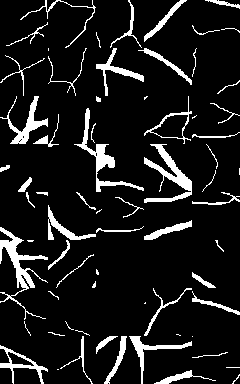

In [6]:
visualize(group_images(patches_masks_train[0:N_sample, :, :, :], 5),
          './'+name_experiment+'/'+"sample_input_masks")  # .show()

In [7]:
#=========== Construct and save the model arcitecture =====
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]

In [8]:
model = get_unet(n_ch, patch_height, patch_width)  #the U-net model











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






In [9]:
print("Check: final output of the network:")
print(model.output_shape)
plot(model, to_file='./'+name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like

json_string = model.to_json()
open('./'+name_experiment+'/'+name_experiment +'_architecture.json', 'w').write(json_string)

Check: final output of the network:
(None, 2304, 2)


10465

In [10]:
#============  Training ==================================
checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+name_experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased


# def step_decay(epoch):
#     lrate = 0.01 #the initial learning rate (by default in keras)
#     if epoch==100:
#         return 0.005
#     else:
#         return lrate
#
# lrate_drop = LearningRateScheduler(step_decay)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
model.fit(patches_imgs_train, patches_masks_train, epochs=N_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpointer])

# 最佳结果
# Epoch 38/150
#  - 251s - loss: 0.1045 - acc: 0.9599 - val_loss: 0.0944 - val_acc: 0.9618
# Epoch 00038: val_loss improved from 0.09506 to 0.09436, saving model to ./test/test_best_weights.h5

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/user02/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  




Train on 171000 samples, validate on 19000 samples
Epoch 1/150
 - 267s - loss: 0.2629 - acc: 0.9102 - val_loss: 0.1673 - val_acc: 0.9406

Epoch 00001: val_loss improved from inf to 0.16727, saving model to ./test/test_best_weights.h5
Epoch 2/150
 - 253s - loss: 0.1624 - acc: 0.9400 - val_loss: 0.1360 - val_acc: 0.9504

Epoch 00002: val_loss improved from 0.16727 to 0.13598, saving model to ./test/test_best_weights.h5
Epoch 3/150
 - 252s - loss: 0.1477 - acc: 0.9450 - val_loss: 0.1158 - val_acc: 0.9552

Epoch 00003: val_loss improved from 0.13598 to 0.11579, saving model to ./test/test_best_weights.h5
Epoch 4/150
 - 251s - loss: 0.1404 - acc: 0.9475 - val_loss: 0.1120 - val_acc: 0.9564

Epoch 00004: val_loss improved from 0.11579 to 0.11196, saving model to ./test/test_best_weights.h5
Epoch 5/150
 - 251s - loss: 0.1352 - acc: 0.9493 - val_loss: 0.1096 - val_acc: 0.9572

Epoch 00005: val_loss improved from 0.11196 to 0.10963, saving model to ./test/test_best_weights.h5
Epoch 6/150
 - 2

In [11]:
#========== Save and test the last model ===================
model.save_weights('./'+name_experiment+'/'+name_experiment +'_last_weights.h5', overwrite=True)
# 保存最后一次训练模型参数为 './test/test_last_weights.h5'

In [14]:
# # test the model
# score = model.evaluate(patches_imgs_test, masks_Unet(patches_masks_test), verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])